## Visualizing Sentence Embeddings with t-SNE
This exploratory mini-project focuses on visualizing the high-dimensional embeddings of sentence data, obtained from the SST-2 sentiment analysis dataset, using BERT embeddings and t-SNE. The goal is to gain insights into the semantic structure captured by BERT and how it relates to sentiment classification.

Key Components:
* **BERT Embeddings**: Leveraged the distilbert-base-uncased model to generate sentence embeddings that encapsulate the contextual information from the SST-2 dataset sentences.

* **t-SNE Visualization**: Applied t-SNE, a powerful dimensionality reduction technique, to project the high-dimensional embeddings onto a 2D plane for easy visualization.

Visualizing the sentiment labels of BERT sentence embeddings can provide insight into how well the pre-trained BERT model captures sentiment information in its embeddings, even if it wasn't fine-tuned specifically for sentiment classification.

In [ ]:
# pip install datasets # HF datasets library

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [14]:
# Ensure we're using a GPU runtime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# We will use SST-2, which is a sentiment analysis dataset

# Load the tokenizer and base model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)

# Load a dataset
dataset = load_dataset('glue', 'sst2', split='validation[:500]')  # Using a smaller subset for efficiency

# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding=True, truncation=True, max_length=128, return_tensors='pt')

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [16]:
# Convert to DataLoader for batch processing
loader = DataLoader(tokenized_datasets, batch_size=10)

In [17]:
# Function to extract embeddings from the model
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Extract the embeddings of the [CLS] token and move to CPU
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu())
    return torch.cat(embeddings)

In [18]:
# Extract embeddings
embeddings = get_embeddings(loader, model)

In [19]:
# Run t-SNE on the embeddings (this part runs on CPU)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())  # Ensure data is in NumPy format for TSNE

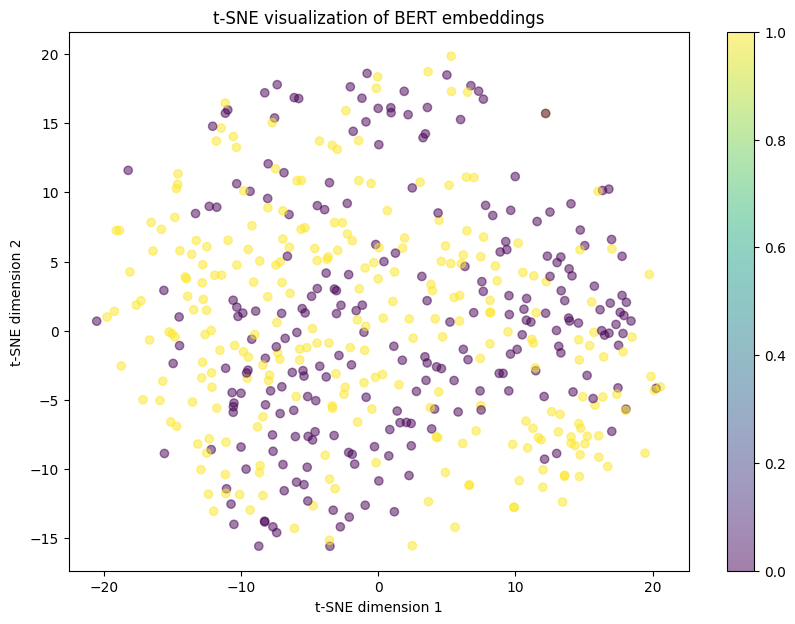

In [20]:
# Plot the 2D embeddings with t-SNE
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dataset['label'], cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of BERT embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

The plot appears to be a t-SNE visualization of BERT embeddings for a set of sentences from the SST-2 sentiment analysis dataset. t-SNE is a dimensionality reduction technique that is particularly good at visualizing high-dimensional data in two or three dimensions. Here's what the plot tells us:

1. **Color Coding**: Each point on the plot represents a sentence from the SST-2 dataset. The color of a point corresponds to the sentiment label of that sentence, with one end of the color spectrum representing one sentiment (e.g., negative) and the other end representing another sentiment (e.g., positive). The color bar on the right indicates the sentiment score assigned to each point.

2. **Clusters**: The arrangement of points in the plot suggests clusters of sentences with similar sentiments. Points that are closer together are more similar in terms of their BERT embeddings, which implies that they have similar meanings or sentiment in the context of the sentences they represent.

3. **Spread of Data**: The spread of points across the plot shows the variation in the dataset. If there were distinct, well-separated clusters, it would indicate that the model's embeddings are very good at differentiating between sentiments. Here, the clusters appear somewhat mixed, suggesting that while there is some differentiation, there is also overlap between sentiments.

4. **Interpretation**: This visualization helps in understanding how well the BERT model is capturing the nuances of language as they relate to sentiment. If we see distinct clusters, that means the embeddings are capturing meaningful differences in sentiment.

    Given that the t-SNE visualization does not show distinct sentiment clusters, it doesn't necessarily mean the model performs poorly at sentiment classification; it may just mean that we might need a larger dataset, a more complex model or that the model hasn't been fine-tuned for this specific task. The model's embeddings contain rich information about language, but without fine-tuning, they may not be optimized to separate sentiments clearly. 

**Note**: t-SNE is stochastic and sensitive to hyperparameters like perplexity and the number of iterations. The plot might look different every time we run t-SNE unless we set a fixed random seed, and tuning the hyperparameters can lead to different insights about the data's structure.